In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit as cs
from scipy.stats import linregress
import requests
from bs4 import BeautifulSoup
import re
import io
from airsea import windstress as ws
from scipy import integrate

In [2]:
def pycno_fit(x,R,Zf,H):
    return -H+(Zf+H)*np.exp(x/R)

def linear(x,a,b):
    return a*x+b

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

def find_nearest(array, value):
    if np.all(np.isnan(array)):
        idx = np.nan
    else:
        array = np.asarray(array)
        idx = np.nanargmin((np.abs(array - value)))
    return idx

def dt2cal(dt):
    """
    Convert array of datetime64 to a calendar array of year, month, day, hour,
    minute, seconds, microsecond with these quantites indexed on the last axis.

    Parameters
    ----------
    dt : datetime64 array (...)
        numpy.ndarray of datetimes of arbitrary shape

    Returns
    -------
    cal : uint32 array (..., 7)
        calendar array with last axis representing year, month, day, hour,
        minute, second, microsecond
    """

    # allocate output 
    out = np.empty(dt.shape + (7,), dtype="u4")
    # decompose calendar floors
    Y, M, D, h, m, s = [dt.astype(f"M8[{x}]") for x in "YMDhms"]
    out[..., 0] = Y + 1970 # Gregorian Year
    out[..., 1] = (M - Y) + 1 # month
    out[..., 2] = (D - M) + 1 # dat
    out[..., 3] = (dt - D).astype("m8[h]") # hour
    out[..., 4] = (dt - h).astype("m8[m]") # minute
    out[..., 5] = (dt - m).astype("m8[s]") # second
    out[..., 6] = (dt - s).astype("m8[us]") # microsecond
    return out

def list_files(url, tag=r'.*\.nc$'):
    """
    Function to create a list of the netCDF data files in the THREDDS catalog
    created by a request to the M2M system.

    :param url: URL to a THREDDS catalog specific to a data request
    :param tag: regex pattern used to distinguish files of interest
    :return: list of files in the catalog with the URL path set relative to the
        catalog
    obtained from 2022 OOIFB workshop 
    """
    with requests.session() as s:
        page = s.get(url).text

    soup = BeautifulSoup(page, 'html.parser')
    pattern = re.compile(tag)
    nc_files = [node.get('href') for node in soup.find_all('a', text=pattern)]
    nc_files = [re.sub('catalog.html\?dataset=', '', file) for file in nc_files]
    return nc_files

def wind_uv_from_spddir(wspd,wdir):
    theta = np.array(wdir)
    theta = theta*np.pi/180
    x = np.sin(theta)
    y = np.cos(theta)
    theta_cart = np.arctan2(y,x)
    u = -wspd*np.cos(theta_cart)
    v = -wspd*np.sin(theta_cart)
    return u,v

def windstress_comps(wspd, wdir, z=10): #requires wspd to be a xarray dataset or dataarray
        tau = ws.stress(wspd,z)
        we,wn = wind_uv_from_spddir(wspd, wdir)
        tau_east = tau*np.cos(np.arctan2(wn,we))
        tau_north = tau*np.sin(np.arctan2(wn,we))
        return tau, tau_east, tau_north
    
def princax(u,v=None):

    # if one input only, decompose complex vector
    if v is None:
        w = np.copy(u)
        u = np.real(w)
        v = np.imag(w)

    # only use finite values for covariance matrix
    ii = np.isfinite(u+v)
    uf = u[ii]
    vf = v[ii]

    # compute covariance matrix
    C = np.cov(uf,vf)

    # calculate principal axis angle (ET, Equation 4.3.23b)
    theta = 0.5*np.arctan2(2.*C[0,1],(C[0,0] - C[1,1])) * 180/np.pi

    # calculate variance along major and minor axes (Equation 4.3.24)
    term1 = C[0,0] + C[1,1]
    term2 = ((C[0,0] - C[1,1])**2 + 4*(C[0,1]**2))**0.5
    major = np.sqrt(0.5*(term1 + term2))
    minor = np.sqrt(0.5*(term1 - term2))

    return theta,major,minor

def rot(u,v,theta):
    w = u + 1j*v
    ang = theta*np.pi/180
    wr = w*np.exp(1j*ang)
    ur = np.real(wr)
    vr = np.imag(wr)
    return ur,vr

def wsIntegrand(tp,t,tau,k,rho=1000):
    return tau[:t+1]/rho*np.exp((tp[:t+1]-t)/k)

In [3]:
nhl_grid = xr.load_dataset('nhl_gridded\\newport_hydrographic_line_gridded_sections.nc')
nhl_grid = nhl_grid.squeeze()
nhl_grid['meters'] = -haversine(nhl_grid['longitude'],nhl_grid['latitude'],-124.0774,nhl_grid['latitude'])
nhl_grid

<xarray.Dataset>
Dimensions:            (pressure: 150, longitude: 56, time: 556)
Coordinates:
    latitude           float32 44.65
  * pressure           (pressure) float32 1.0 2.0 3.0 4.0 ... 148.0 149.0 150.0
  * longitude          (longitude) float32 235.4 235.4 235.4 ... 235.9 235.9
  * time               (time) datetime64[ns] 1997-03-21T16:34:13.124999936 .....
Data variables:
    temperature        (longitude, pressure, time) float32 nan nan ... nan nan
    salinity           (longitude, pressure, time) float32 nan nan ... nan nan
    potential_density  (longitude, pressure, time) float32 nan nan ... nan nan
    spiciness          (longitude, pressure, time) float32 nan nan ... nan nan
    dissolved_oxygen   (longitude, pressure, time) float32 nan nan ... nan nan
    meters             (longitude) float64 -45.3 -44.51 -43.71 ... -2.578 -1.791
Attributes: (12/67)
    title:                           Interplolated Newport Hydrographic Line ...
    summary:                         This data set contains interpolated data...
    date_created:                    2022-01-02T23:31:27
    history:                         Created: 2022-01-02T23:31:27
    keywords:                        OSU, NOAA, NWFSC, CIMRS, Newport Hydrogr...
    keyword_vocabulary:              GCMD
    ...                              ...
    keywords_vocabulary:             GCMD Science Keywords
    date_modified:                   2021-11-08T00:00:00Z
    date_issued:                     2021-11-08T00:00:00Z
    geospatial_vertical_units:       dbar
    geospatial_vertical_resolution:  1 dbar
    geospatial_vertical_positive:    down

In [4]:
pycno_depth = np.nan*np.zeros((len(nhl_grid['meters']),len(nhl_grid['time'])))

for i,x in enumerate(nhl_grid['meters']):
    for j,t in enumerate(nhl_grid['time']):
        index = find_nearest(nhl_grid['potential_density'][i,:,j],25.8)
        if ~np.isnan(index):
            pycno_depth[i][j] = nhl_grid['pressure'][index]

In [5]:
pycno_depth = np.nan*np.zeros((len(nhl_grid['meters']),len(nhl_grid['time'])))

for i,x in enumerate(nhl_grid['meters']):
    for j,t in enumerate(nhl_grid['time']):
        mask = ~np.isnan(nhl_grid['potential_density'][i,:,j])
        temp = nhl_grid['potential_density'][i,:,j][mask]
        if len(temp>0):
            try:
                inter = interp1d(nhl_grid['potential_density'][i,:,j][mask],nhl_grid['pressure'][mask])
                pycno_depth[i][j] = inter(25.8)
            except ValueError:
                pycno_depth[i][j] = np.nan
                pass
        #if ~np.isnan(index):
        #pycno_depth[i][j] = nhl_grid['pressure'][index]
#add pycno depth to nhl_grid netcdf
nhl_grid['pycno_depth'] = (['longitude','time'],-pycno_depth)

C:\Users\asche\.conda\envs\po\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\asche\.conda\envs\po\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


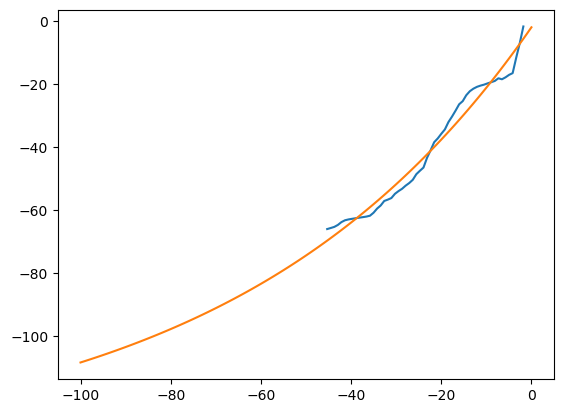

In [6]:
for i in range(29,30):
    if ~np.any(np.isnan(pycno_depth.T[i,24:45])):
        plt.plot(nhl_grid['meters'],-pycno_depth.T[i],label=i)
        plt.plot(np.arange(-100,1),pycno_fit(np.arange(-100,1),65.9647933,-1.8516725,138.22141689))
#plt.legend()
#plt.axhline(-25.8)

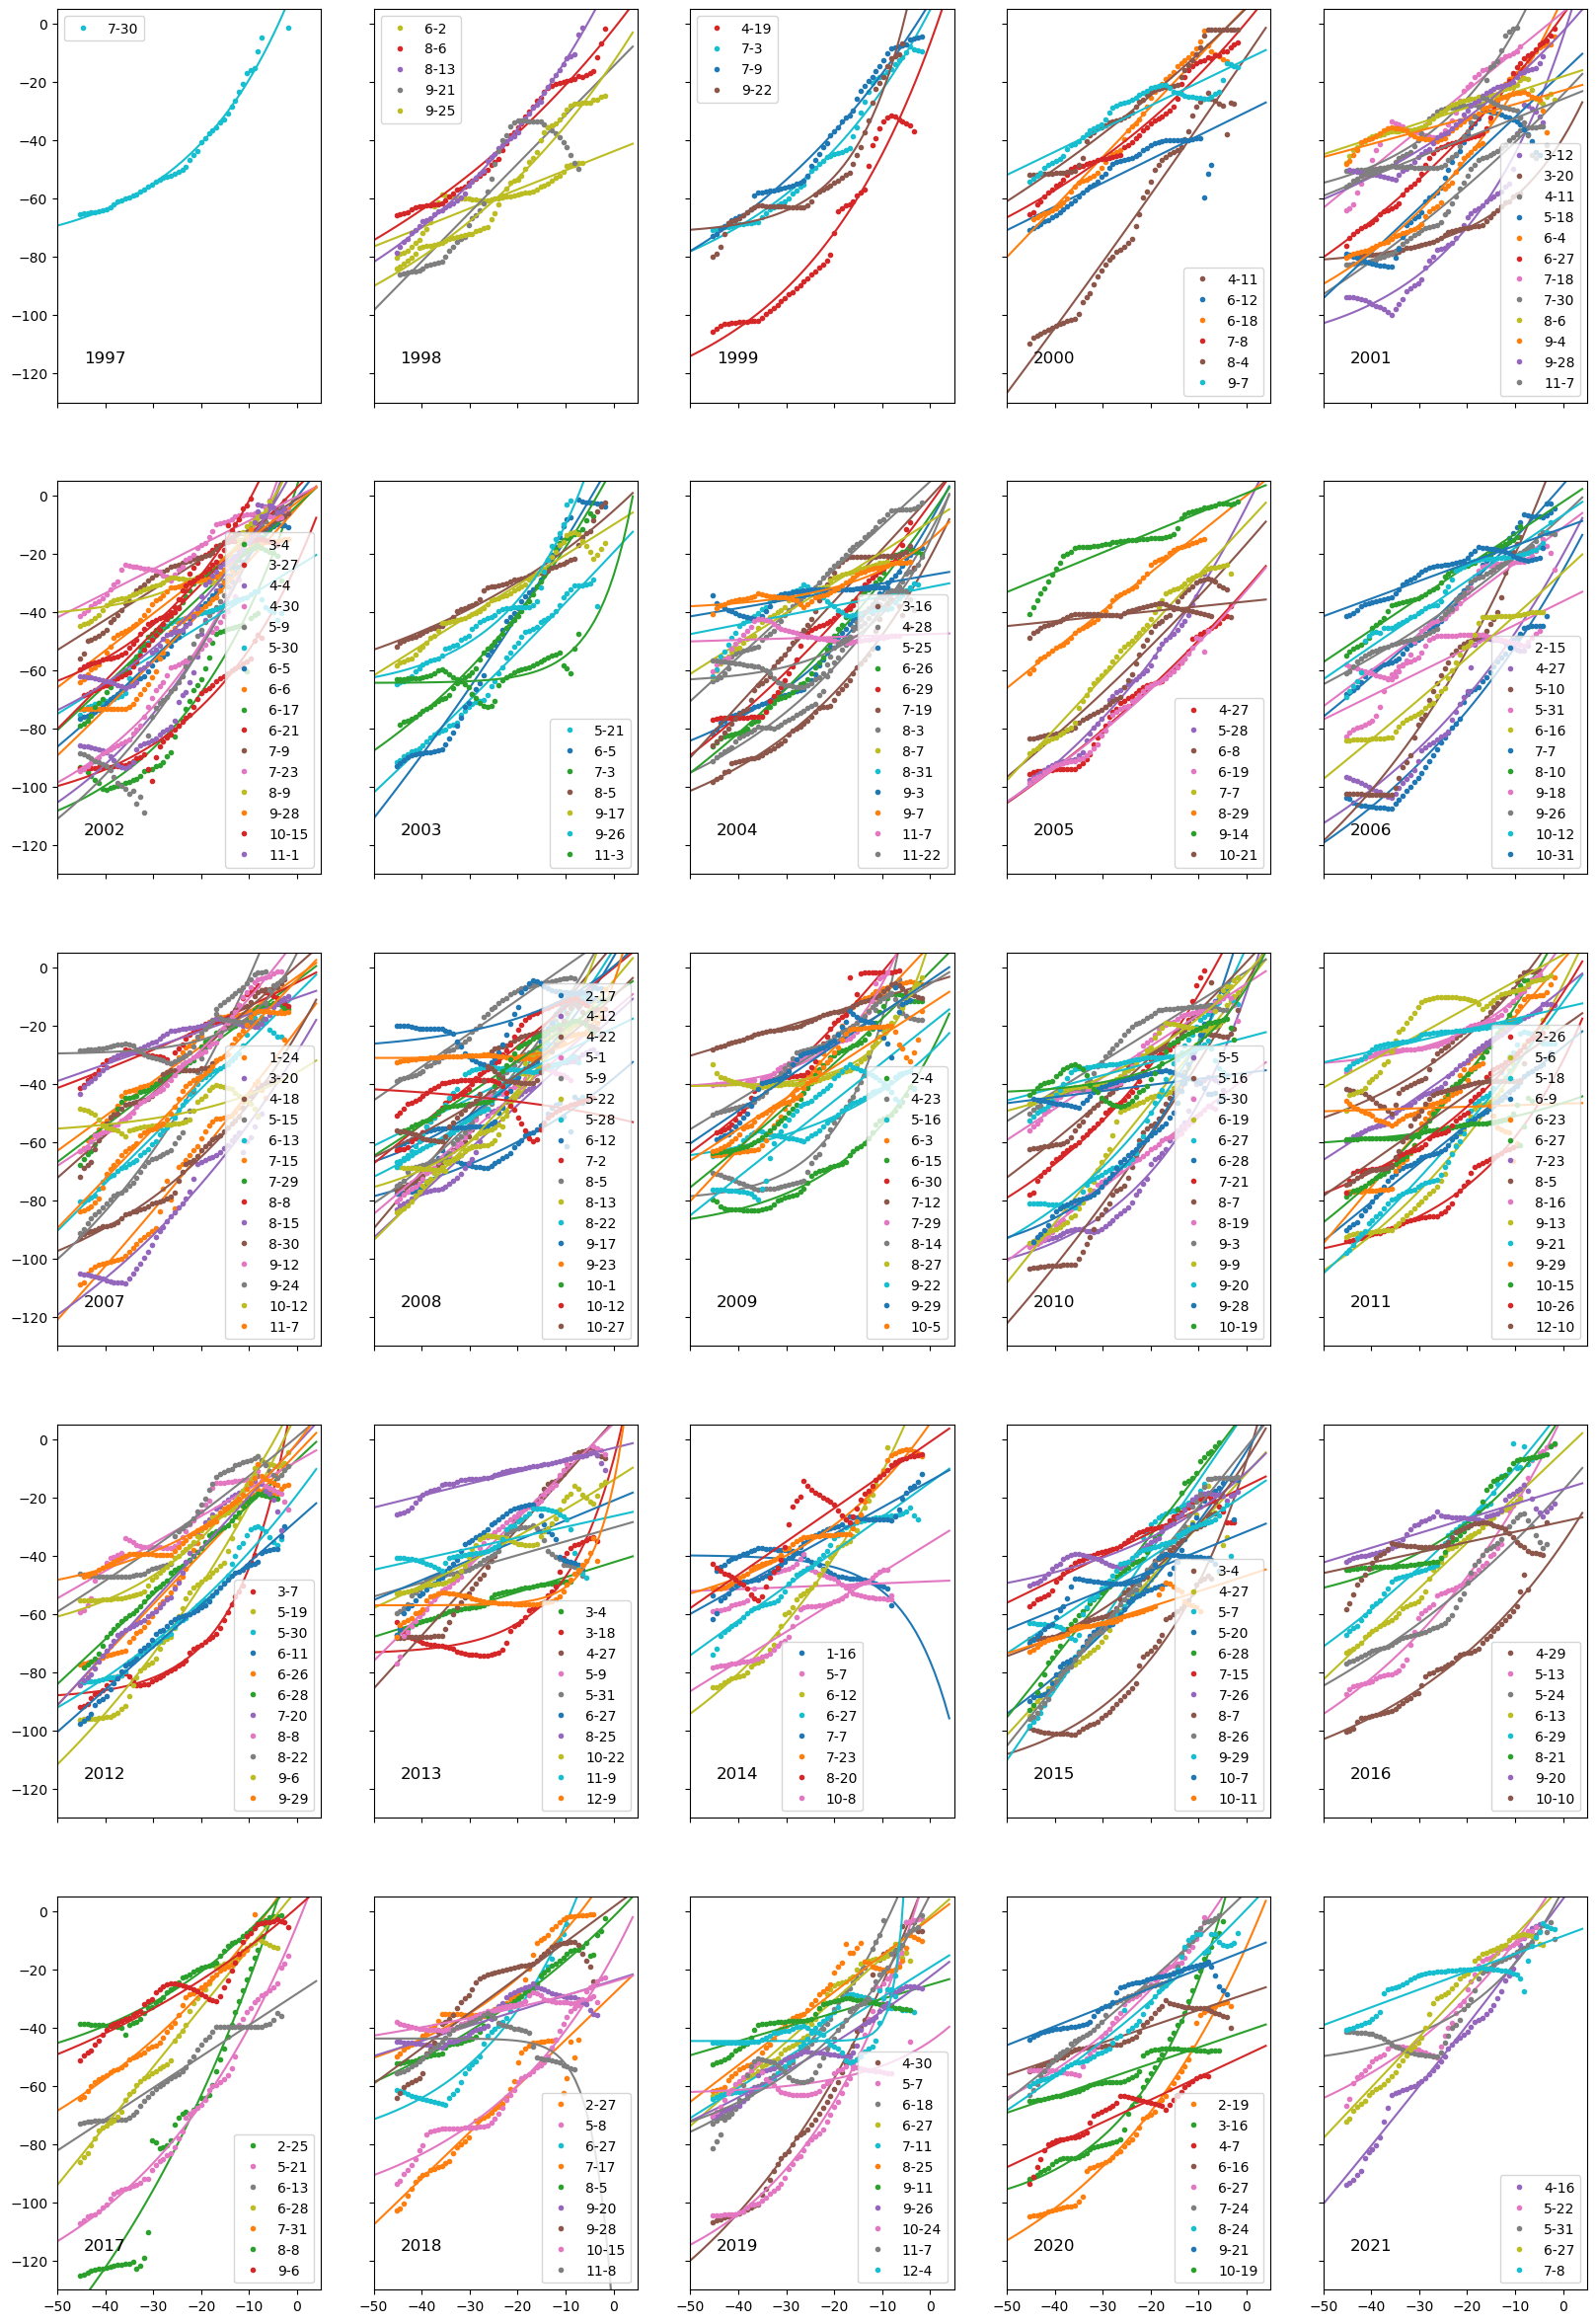

In [7]:
col = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
trange = np.arange(np.datetime64('1997'), np.datetime64('2022'), np.timedelta64(1, 'Y'), dtype='datetime64[Y]')
tdelta = np.timedelta64(1, 'Y')
rows = 5
cols = 5
fig,axs = plt.subplots(5,5,figsize=(20,30),sharex=True,sharey=True)
for r in range(rows):
    for c in range(cols):
        mask = ((nhl_grid['time'] >= trange[5*r+c%5]) & 
                (nhl_grid['time'] < trange[5*r+c%5] + tdelta))
        for i,(t,d) in enumerate(zip(nhl_grid['time'][mask].values,-pycno_depth.T[mask])):
            mask = ~np.isnan(d)
            if len(d[mask]) > 45:
                R,Zf,H = cs(pycno_fit,nhl_grid['meters'][mask],d[mask],p0=[50,0,125])[0]
                ymd = dt2cal(t)[0:3]
                axs[r][c].plot(nhl_grid['meters'],d,'.',label=f'{ymd[1]}-{ymd[2]}',c=col[i%len(col)])
                axs[r][c].plot(np.arange(-50,5),pycno_fit(np.arange(-50,5),R,Zf,H),c=col[i%len(col)])
        axs[r][c].annotate(ymd[0], xy=(0.1, 0.1), xycoords='axes fraction', fontsize=12)
        axs[r][c].legend()
        axs[r][c].set_ylim([-130,5])
        axs[r][c].set_xlim([-50,5])

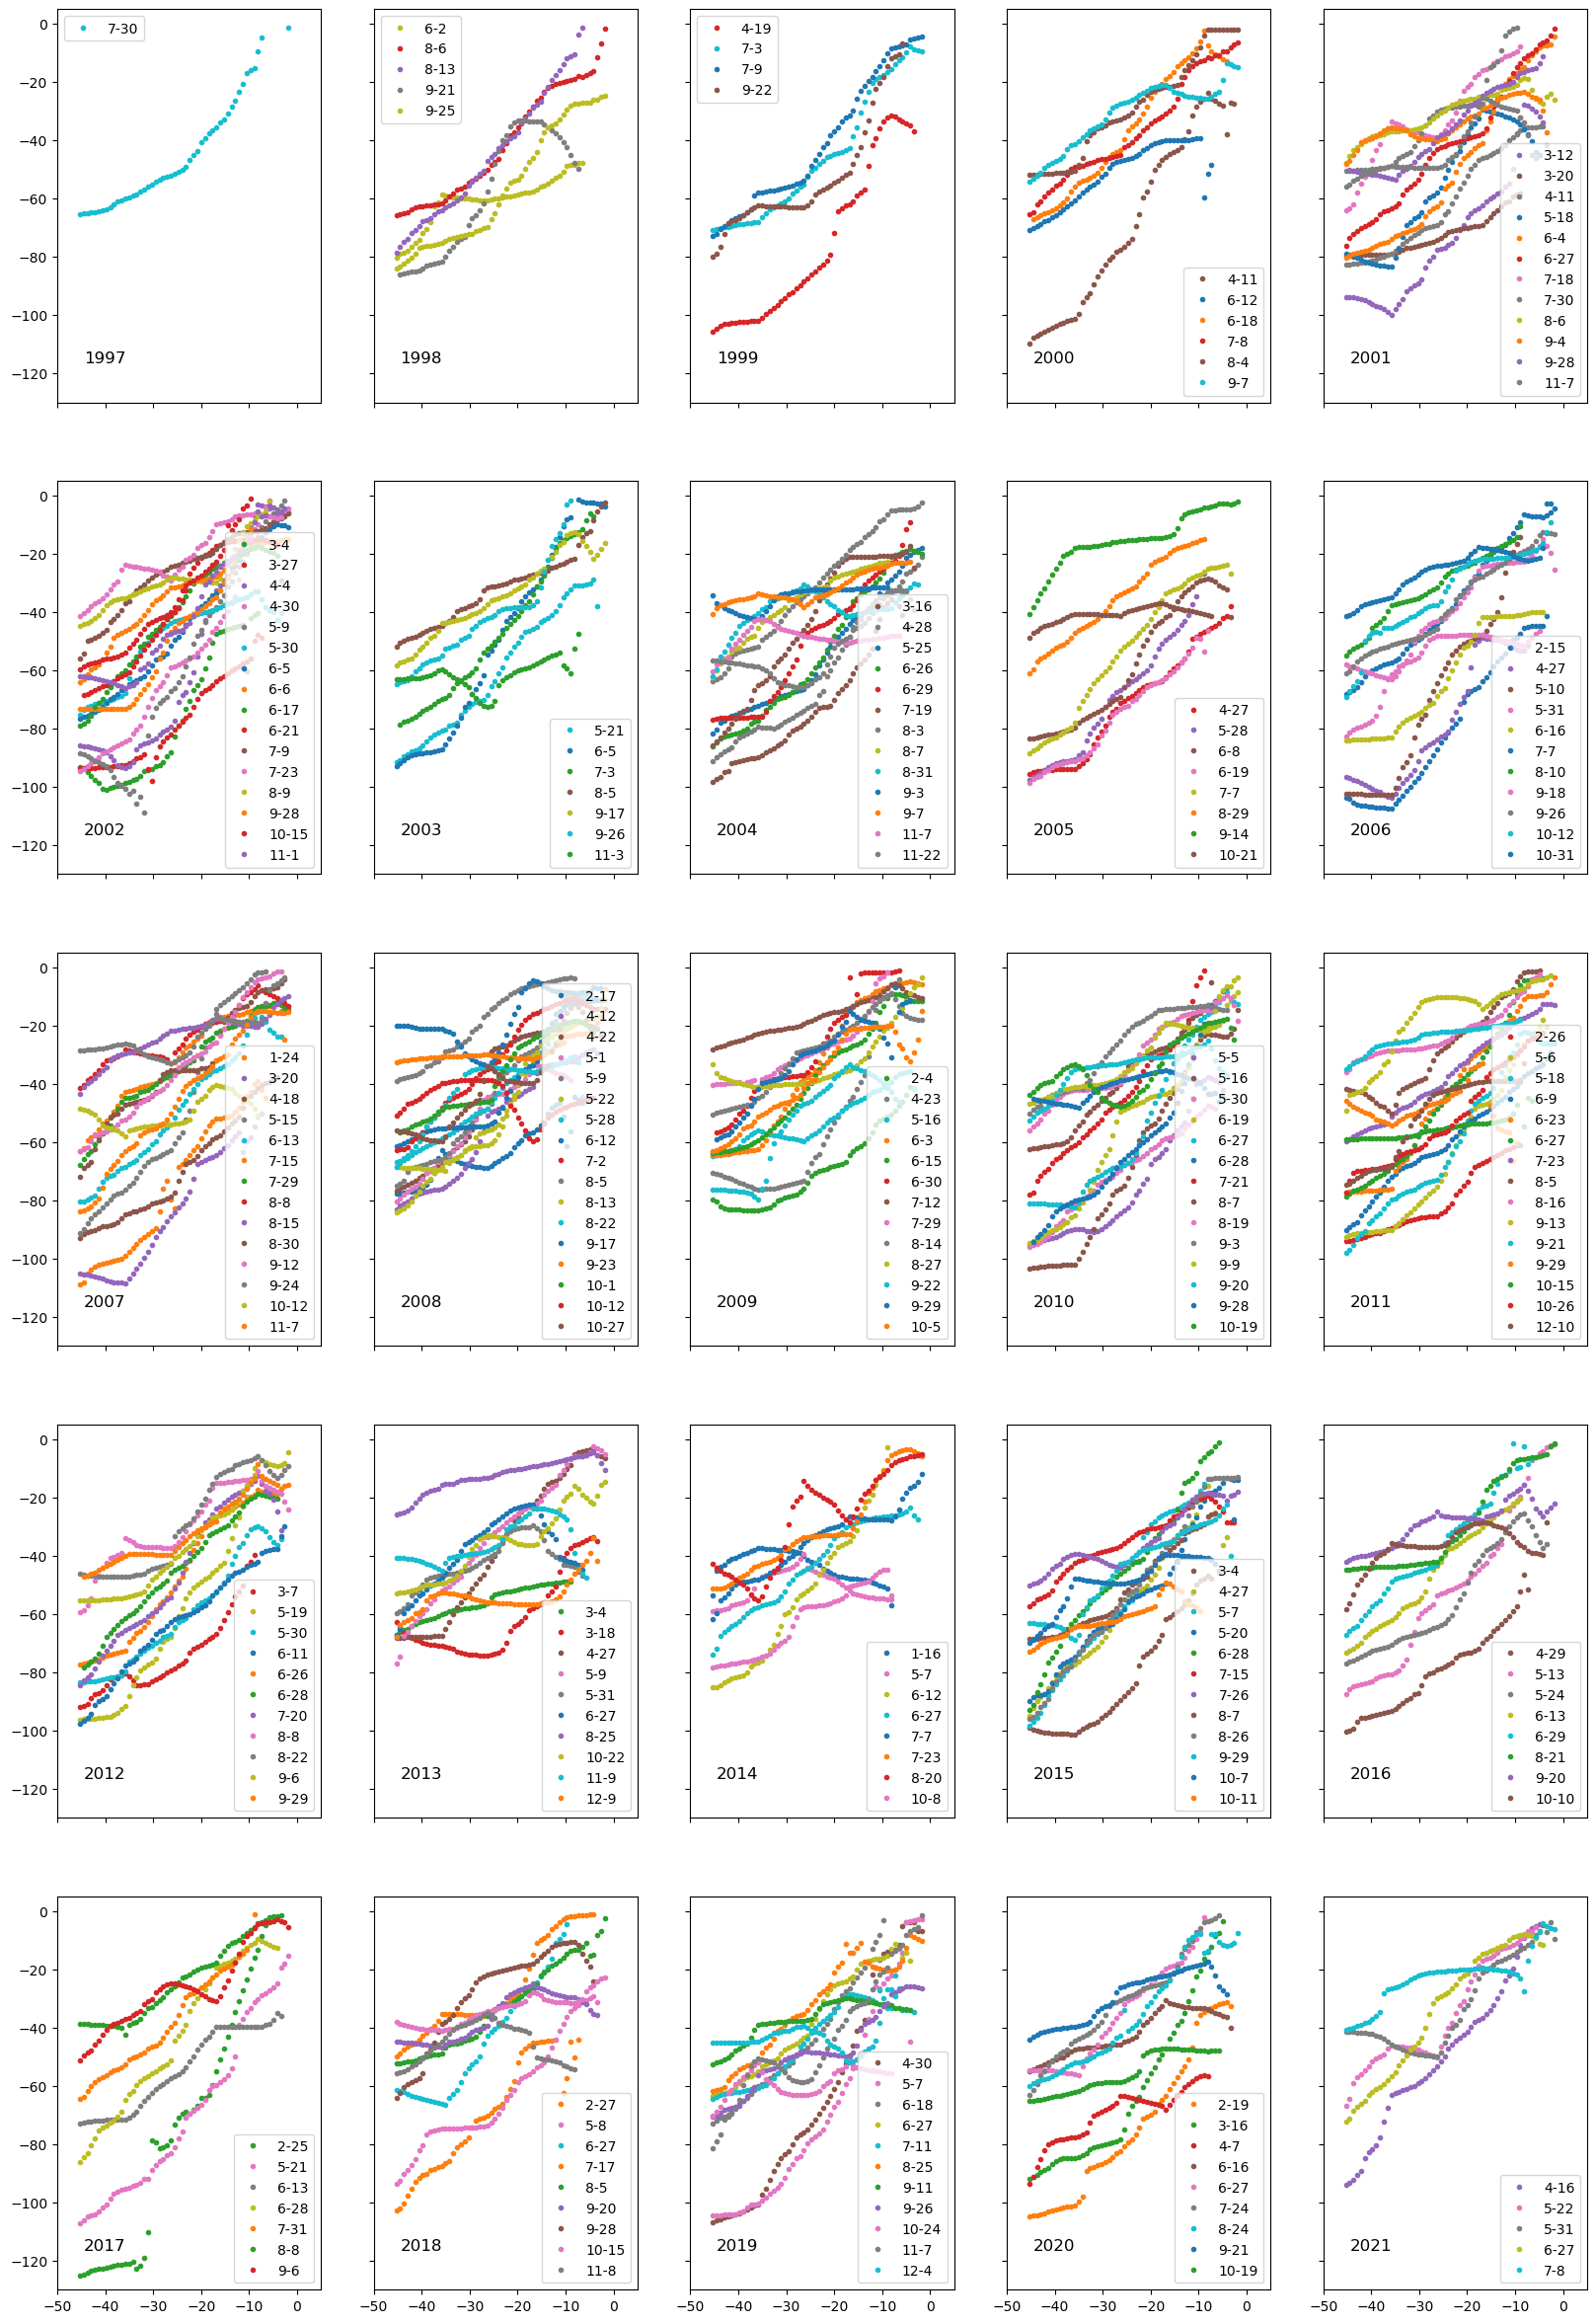

In [8]:
col = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
trange = np.arange(np.datetime64('1997'), np.datetime64('2022'), np.timedelta64(1, 'Y'), dtype='datetime64[Y]')
tdelta = np.timedelta64(1, 'Y')
rows = 5
cols = 5
fig,axs = plt.subplots(5,5,figsize=(20,30),sharex=True,sharey=True)
for r in range(rows):
    for c in range(cols):
        mask = ((nhl_grid['time'] >= trange[5*r+c%5]) & 
                (nhl_grid['time'] < trange[5*r+c%5] + tdelta))
        for i,(t,d) in enumerate(zip(nhl_grid['time'][mask].values,-pycno_depth.T[mask])):
            mask = ~np.isnan(d)
            if len(d[mask]) > 45:
                #R,Zf,H = cs(pycno_fit,nhl_grid['meters'][mask],d[mask],p0=[50,0,125])[0]
                ymd = dt2cal(t)[0:3]
                axs[r][c].plot(nhl_grid['meters'],d,'.',label=f'{ymd[1]}-{ymd[2]}',c=col[i%len(col)])
                #axs[r][c].plot(np.arange(-50,5),pycno_fit(np.arange(-50,5),R,Zf,H),c=col[i%len(col)])
        axs[r][c].annotate(ymd[0], xy=(0.1, 0.1), xycoords='axes fraction', fontsize=12)
        axs[r][c].legend()
        axs[r][c].set_ylim([-130,5])
        axs[r][c].set_xlim([-50,5])

In [9]:
R = np.nan*np.zeros(len(pycno_depth.T))
R_err = np.nan*np.zeros(len(pycno_depth.T))
Zf = np.nan*np.zeros(len(pycno_depth.T))
Zf_err = np.nan*np.zeros(len(pycno_depth.T))
H = np.nan*np.zeros(len(pycno_depth.T))
H_err = np.nan*np.zeros(len(pycno_depth.T))

for i,d in enumerate(-pycno_depth.T):
    mask = ~np.isnan(d)
    if len(d[mask]) > 40:
        (R[i],Zf[i],H[i]),cov = cs(pycno_fit,nhl_grid['meters'][mask],d[mask],p0=[50,0,125])
        (R_err[i],Zf_err[i],H_err[i]) = 1.96*np.sqrt(np.diagonal(cov))
#np.sqrt(np.diagonal(cov))
nhl_grid['R'] = (['time'],R)
nhl_grid['Zf'] = (['time'],Zf)
nhl_grid['H'] = (['time'],H)

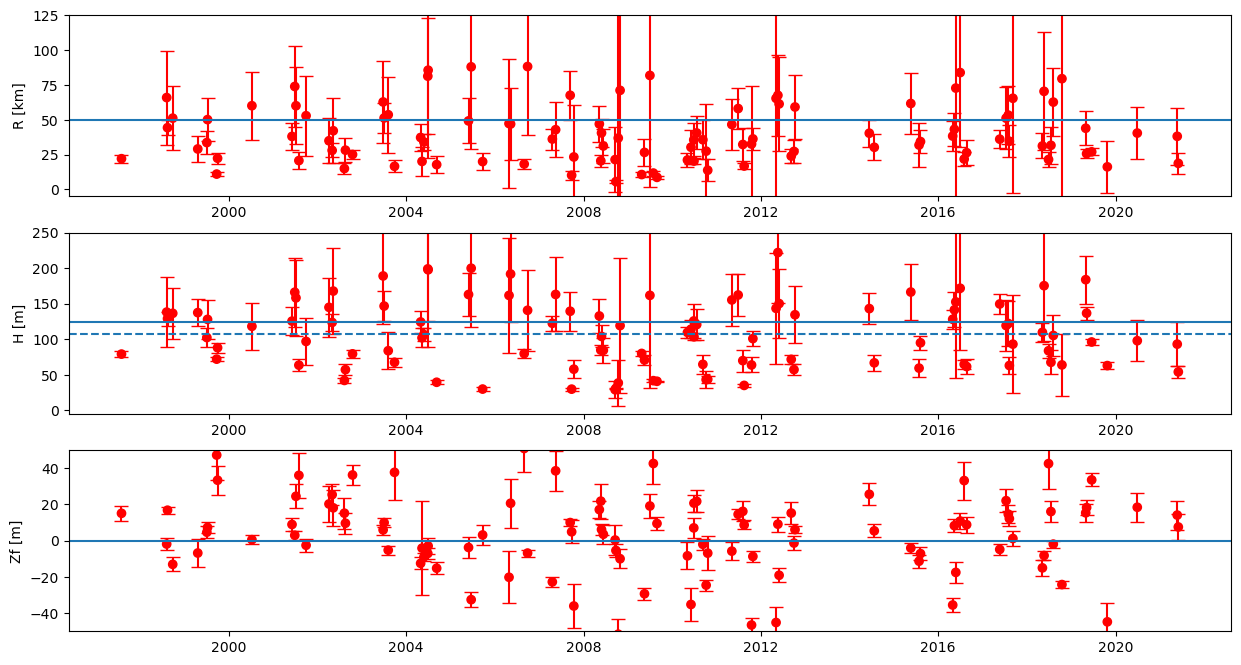

In [10]:
fig,axs = plt.subplots(3,1,figsize=(15,8))
mask = ((R < 100) & (Zf < 100) & (Zf > -100) & (H < 500) & (H > 0))
m = dt2cal(nhl_grid['time'].values[mask]).T[1]
col = np.where(((m>=4) & (m<=10)),'r','#0f0f0f00')
m = dt2cal(nhl_grid['time'].values).T[1]
summer = ((m>=4) & (m<=10) & (mask))
#mask = (R < 100)
axs[0].scatter(nhl_grid['time'][mask],R[mask],c=col)
for t,r,err,color in zip(nhl_grid['time'].values[mask],R[mask],R_err[mask],col):
    axs[0].errorbar(x=t,y=r,yerr=err,fmt='none',c=color,capsize=5)
axs[0].axhline(50)
axs[0].set_ylabel('R [km]')
axs[0].set_ylim([-5,125])
#mask = ((H < 500) & (H > 0))
axs[1].scatter(nhl_grid['time'][mask],H[mask],c=col)
for t,h,err,color in zip(nhl_grid['time'].values[mask],H[mask],H_err[mask],col):
    axs[1].errorbar(x=t,y=h,yerr=err,fmt='none',c=color,capsize=5)
axs[1].axhline(125)
axs[1].axhline(np.nanmean(H[summer]),ls='--')
axs[1].set_ylabel('H [m]')
axs[1].set_ylim([-5,250])
#mask = ((Zf < 100) & (Zf > -100))
axs[2].scatter(nhl_grid['time'][mask],Zf[mask],c=col)
for t,z,err,color in zip(nhl_grid['time'].values[mask],Zf[mask],Zf_err[mask],col):
    axs[2].errorbar(x=t,y=z,yerr=err,fmt='none',c=color,capsize=5)
axs[2].axhline(0)
axs[2].set_ylabel('Zf [m]')
axs[2].set_ylim([-50,50])
pass

# Finding zf/wind relationship

In [11]:
nhl_grid_rs = nhl_grid.resample(time='1D').mean()

In [12]:
#get wind data
#construct the NDBC THREDDS catalog URL for this data set
url_w = "https://dods.ndbc.noaa.gov/thredds/catalog/data/stdmet/nwpo3/catalog.html";
url_w #check to ensure URL is correct

'https://dods.ndbc.noaa.gov/thredds/catalog/data/stdmet/nwpo3/catalog.html'

In [13]:
tag = r'[1][9][9][8-9].*\.nc$|[2][0][0|1][0-9].*\.nc$|[2][0][2][0-2].*\.nc$' #setup regex for files we want (.=anything,, *=repeats, $=end of line, |=or)
nc_files = list_files(url_w, tag)
file_url = 'https://dods.ndbc.noaa.gov/thredds/fileServer/'
nc_url_w = [file_url + i + '#mode=bytes' for i in nc_files] #combine files, add mode to ensure download works
print(nc_files)
nc_url_w #can check urls here
#https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/nwpo3/nwpo3h2014.nc

['data/stdmet/nwpo3/nwpo3h1998.nc', 'data/stdmet/nwpo3/nwpo3h1999.nc', 'data/stdmet/nwpo3/nwpo3h2000.nc', 'data/stdmet/nwpo3/nwpo3h2001.nc', 'data/stdmet/nwpo3/nwpo3h2002.nc', 'data/stdmet/nwpo3/nwpo3h2003.nc', 'data/stdmet/nwpo3/nwpo3h2004.nc', 'data/stdmet/nwpo3/nwpo3h2005.nc', 'data/stdmet/nwpo3/nwpo3h2006.nc', 'data/stdmet/nwpo3/nwpo3h2007.nc', 'data/stdmet/nwpo3/nwpo3h2008.nc', 'data/stdmet/nwpo3/nwpo3h2009.nc', 'data/stdmet/nwpo3/nwpo3h2010.nc', 'data/stdmet/nwpo3/nwpo3h2011.nc', 'data/stdmet/nwpo3/nwpo3h2012.nc', 'data/stdmet/nwpo3/nwpo3h2013.nc', 'data/stdmet/nwpo3/nwpo3h2014.nc', 'data/stdmet/nwpo3/nwpo3h2015.nc', 'data/stdmet/nwpo3/nwpo3h2016.nc', 'data/stdmet/nwpo3/nwpo3h2017.nc', 'data/stdmet/nwpo3/nwpo3h2018.nc', 'data/stdmet/nwpo3/nwpo3h2019.nc', 'data/stdmet/nwpo3/nwpo3h2020.nc', 'data/stdmet/nwpo3/nwpo3h2021.nc', 'data/stdmet/nwpo3/nwpo3h2022.nc']


['https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h1998.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h1999.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2000.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2001.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2002.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2003.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2004.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2005.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2006.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo3h2007.nc#mode=bytes',
 'https://dods.ndbc.noaa.gov/thredds/fileServer/data/stdmet/nwpo3/nwpo

In [14]:
ds_w,mask_w = [],[]  #empty arrays for data masks and datasets
for i,f in enumerate(nc_url_w):
    r = requests.get(f, timeout=(3.05, 120)) #request url
    if r.ok:                                #ensure request worked
        ds_w.append(xr.load_dataset(io.BytesIO(r.content))) #load datasets
        #ds_w[i].swap_dims({'obs':'time'}) #swap dims
        #mask_w.append((~np.isnan(ds[i]['nitrate_concentration'].values)) & (ds[i]['nitrate_concentration'].values<=100) & (ds[i]['deployment'].values!=16)) #mask for selected conditions
        #labels = [d['deployment'][0].values for d in ds]   #create deployment labels for plotting (add other useful labels here too)

In [15]:
#remove unnecessary coords
for i,w in enumerate(ds_w):
    ds_w[i] = w.squeeze()

In [16]:
for i,w in enumerate(ds_w):
    ds_w[i]['wind_east'],ds_w[i]['wind_north'] = wind_uv_from_spddir(w['wind_spd'], w['wind_dir'])
    tau, tau_east, tau_north = windstress_comps(w['wind_spd'], w['wind_dir'], z=9.8+9.1)
    ds_w[i]['tau_east'] = tau_east
    ds_w[i]['tau_north'] = tau_north
    #ds_w[i]['cd'] = (['time'],cd)
    

#flatten array to determine principal axis based on all available data from data start to data end
ds_w_east = np.array([item for sublist in ds_w for item in sublist['wind_east'].values])
ds_w_north = np.array([item for sublist in ds_w for item in sublist['wind_north'].values])
ds_w_time = np.array([item for sublist in ds_w for item in sublist['time'].values])

In [17]:
#mask times outside deployment ranges
#prin_mask = ((ds_w_time >= dep_sta[0]) & (ds_w_time <= dep_end[-1]))
#find principal axis of all data points within deployment range
theta, major, minor = princax(ds_w_east, ds_w_north)
print(theta)
for i,w in enumerate(ds_w):
    ds_w[i]['cs'],ds_w[i]['as'] = rot(w['wind_east'], w['wind_north'], -theta+90)
    ds_w[i]['tau_x'],ds_w[i]['tau_y'] = rot(w['tau_east'],w['tau_north'],-theta+90)

85.65112044887407


In [18]:
#resample to 1D time intervals with mean method
ds_w_r = []
for i,w in enumerate(ds_w):
    ds_w_r.append(w.resample(time="1D").mean())  
ds_w_rs = xr.concat(ds_w_r, dim='time') #concatenate wind datasets onto one time series
#define day number since Jan 1st 2014 for integration
ds_w_rs['day_num'] = (['time'],np.arange(len(ds_w_rs['time'])))

In [19]:
avg_len = 8
fout = np.nan*np.zeros(len(ds_w_rs['day_num']))
for i,f in enumerate(fout):
    temp = wsIntegrand(ds_w_rs['day_num'].values,ds_w_rs['day_num'].values[i],
                   ds_w_rs['tau_y'].values,avg_len)
    mask = ~np.isnan(temp)
    fout[i] = integrate.simpson(temp[mask],ds_w_rs['day_num'].values[:i+1][mask])*86400
ds_w_rs['as_int'] = (['time'],fout)

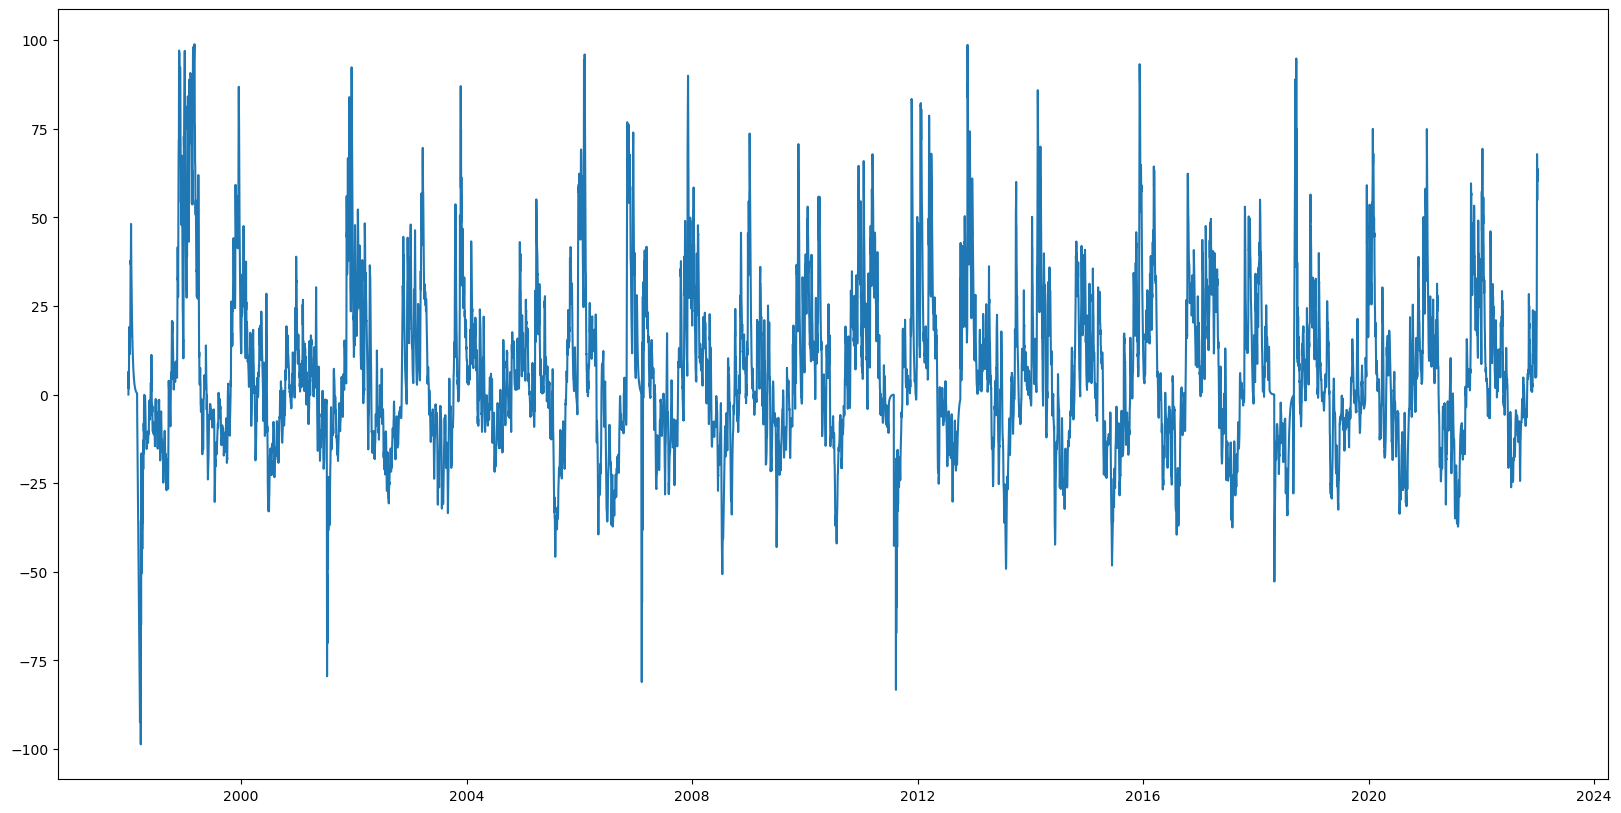

In [20]:
#just making sure the exponential integral is working correctly
plt.figure(figsize=(20,10))
mask = ((ds_w_rs['as_int'] < 100) & (ds_w_rs['as_int'] > -100))
#plt.plot(ds_w_rs['time'][mask],ds_w_rs['tau_y'][mask]*100)
plt.plot(ds_w_rs['time'][mask],ds_w_rs['as_int'][mask])

In [21]:
#align wind, grid data
ds_w_rs,nhl_grid_rs = xr.align(ds_w_rs,nhl_grid_rs)

LinregressResult(slope=-0.9646209107997332, intercept=-12.5527671752638, rvalue=-0.649121777370398, pvalue=2.4807699729279417e-33, stderr=0.06944038600483139, intercept_stderr=1.1111879051533329)

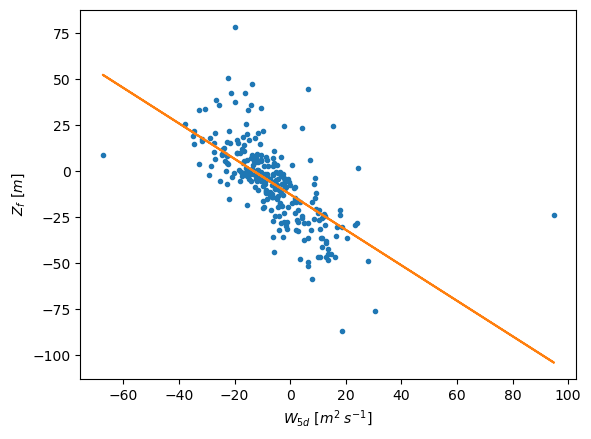

In [22]:
#plot zf vs. wind
#here I include all data that is "reasonable" as defined in mask below
mask = ((nhl_grid_rs['Zf'] < 100) & (nhl_grid_rs['Zf']  > -100))
fit = linregress(ds_w_rs['as_int'][mask],nhl_grid_rs['Zf'][mask])
plt.plot(ds_w_rs['as_int'][mask],nhl_grid_rs['Zf'][mask],'.')
plt.plot(ds_w_rs['as_int'][mask],ds_w_rs['as_int'][mask]*fit[0]+fit[1])
plt.xlabel('$W_{5d}$ [$m^2 \; s^{-1}$]')
plt.ylabel('$Z_f$ [$m$]')
fit

LinregressResult(slope=-1.2299565382228765, intercept=-14.312064661504879, rvalue=-0.3539782329050644, pvalue=1.893692950073437e-09, stderr=0.19777015023832287, intercept_stderr=3.2066566479713616)

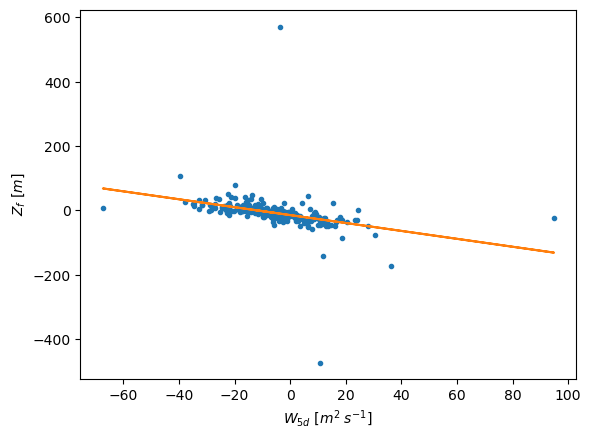

In [23]:
#plot zf vs. wind
#here I include all data available 
mask = ((~np.isnan(nhl_grid_rs['Zf'])) & (~np.isnan(nhl_grid_rs['Zf'])))
fit = linregress(ds_w_rs['as_int'][mask],nhl_grid_rs['Zf'][mask])
plt.plot(ds_w_rs['as_int'][mask],nhl_grid_rs['Zf'][mask],'.')
plt.plot(ds_w_rs['as_int'][mask],ds_w_rs['as_int'][mask]*fit[0]+fit[1])
plt.xlabel('$W_{5d}$ [$m^2 \; s^{-1}$]')
plt.ylabel('$Z_f$ [$m$]')
fit

(-1.0976090321772198, -13.151550877908909)

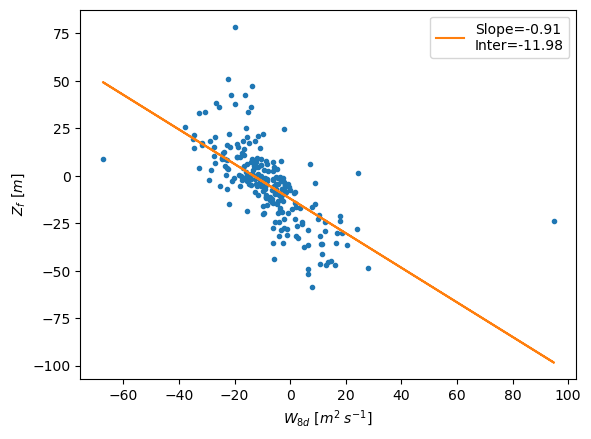

In [24]:
#here I only include data from April-October
m = dt2cal(nhl_grid_rs['time'].values).T[1]
mask =((nhl_grid_rs['Zf'] < 100) & (nhl_grid_rs['Zf']  > -100))
summer = ((m>=4) & (m<=10) & (mask))
fit = linregress(ds_w_rs['as_int'][summer],nhl_grid_rs['Zf'][summer])
plt.plot(ds_w_rs['as_int'][summer],nhl_grid_rs['Zf'][summer],'.')
plt.plot(ds_w_rs['as_int'][summer],ds_w_rs['as_int'][summer]*fit[0]+fit[1],
         label=f'Slope={fit[0]:.2f}\nInter={fit[1]:.2f}')
plt.xlabel('$W_{8d}$ [$m^2 \; s^{-1}$]')
plt.ylabel('$Z_f$ [$m$]')
plt.legend()
#compare results below for rough estimates from AB 2002: a~=-0.85,b~=-23
1/fit[0],-fit[1]/fit[0]

In [25]:
#parameters for W5d as a function of Zf for model
1/fit[0]*-20-fit[1]/fit[0]

8.800629765635486